#### Credits to Foam Liu https://github.com/foamliu/Car-Recognition

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input/devkit/devkit"))

import scipy.io
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
import cv2#reading and resizing                      
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from resnet import resnet18, resnet34, resnet50, resnet101, resnet152

# Prepare Data

In [2]:
meta_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_meta.mat')
train_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_train_annos.mat')
test_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_test_annos.mat')
annos_dict = [train_annos_dict,test_annos_dict]

In [3]:
# Load cars_meta into dataFrame
meta_df = pd.DataFrame.from_dict(meta_dict['class_names'])
meta_df = meta_df.stack()
len(meta_df)

196

In [4]:
# Load train and test annos into dataFrame
for i,d in enumerate(annos_dict):
    r,c = d['annotations'].shape
    d_reshape = d['annotations'].reshape(c,r)
    d_reshape.shape
    
    if i == 0:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['class'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'class',5:'fname'},inplace=True)
    else:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'fname'},inplace=True)

    for col in d_df.columns:
        l = d_df[col]  
        flatten = lambda l: [item for sublist in l for item in sublist]
        if col == 'fname':
            pass
        else:
            d_df[col] = d_df[col].apply(flatten)

        d_df[col] = d_df[col].apply(lambda i: i[0])
    
    if i == 0:
        train_annot_df = d_df.copy()
    else:
        test_annot_df = d_df.copy()

# Split data to train, evaluation and test

In [5]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [6]:
X = train_annot_df.drop('class',axis=1)
y = train_annot_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

train_df = pd.concat([X_train,y_train],axis=1)
val_df = pd.concat([X_val,y_val],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

In [7]:
# Convert column class to string
train_df['class'] = train_df['class'].apply(str)
val_df['class'] = val_df['class'].apply(str)
test_df['class'] = test_df['class'].apply(str)

In [8]:
print(train_annot_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(8144, 6)
(3990, 6)
(1710, 6)
(2444, 6)


In [9]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

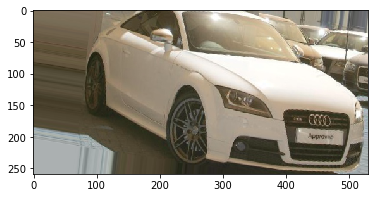

In [10]:
img = cv2.imread('Cars_Dataset_Stanford/cars_train_cropped/00001.jpg')
plt.imshow(image_gen.random_transform(img))
#plt.imshow(img)

# Find image size median

In [11]:
# Find median of image size
height_list = []
width_list = []

for i in range(len(train_annot_df)):
    path = 'Cars_Dataset_Stanford/cars_train_cropped/' + train_annot_df['fname'][i]
    img = cv2.imread(path)
    height,width = img.shape[:2]
    height_list.append(height)
    width_list.append(width)

In [12]:
img_height = int(np.median(height_list))
img_width = int(np.median(width_list))

print(img_height)
print(img_width)

260
504


In [15]:
image_shape = (img_height, img_width,3)

# Creating the Model

In [ ]:
'''
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer
model.add(Dense(196))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
'''

In [21]:
n_classes = len(meta_df)

model = resnet18(image_shape,n_classes)

In [23]:
#model.summary()

# Training the Model

In [24]:
patience = 50
verbose = 1
batch_size = 16
num_epochs = 100000
patience = 50

In [25]:
tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
trained_models_path = 'models/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

In [27]:
batch_size = 16

train_generator = image_gen.flow_from_dataframe(
                    dataframe = train_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

Found 3990 validated image filenames belonging to 196 classes.


In [34]:
valid_generator = image_gen.flow_from_dataframe(
                    dataframe = val_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

Found 1710 validated image filenames belonging to 196 classes.


In [28]:
test_generator = image_gen.flow_from_dataframe(
                    dataframe = test_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

Found 2444 validated image filenames belonging to 196 classes.


In [31]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

3990
1710
2444


In [32]:
num_train_samples = len(train_df)
num_valid_samples = len(val_df)
num_test_samples = len(test_df)

In [ ]:
# fine tune the model
results =   model.fit_generator(
            train_generator,
            steps_per_epoch=num_train_samples / batch_size,
            validation_data=valid_generator,
            validation_steps=num_valid_samples / batch_size,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=verbose)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100000
230/249 [==========================>...] - ETA: 1:38 - loss: 5.4196 - acc: 0.0082

In [ ]:
model.save('cars_090619.h5')

In [ ]:
plt.plot(results.history['acc'])

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 394006020750715990
]
